In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('aug_train.csv')
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [3]:
df.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

In [4]:
categorical_columns = [
    'city',
    'gender',
    'relevent_experience',
    'enrolled_university',
    'education_level',
    'major_discipline',
    'experience',
    'company_size',
    'company_type',
    'last_new_job',
]

numerical = [
    'city_development_index',
    'training_hours'
]

In [20]:
df = df.drop('enrollee_id', axis=1)

In [5]:
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')
df['company_size'] = df['company_size'].str.replace('<10', '0')
df['experience'] = df['experience'].str.replace('<1', '0')

In [6]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,male,has_relevent_experience,no_enrollment,graduate,stem,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,male,no_relevent_experience,no_enrollment,graduate,stem,15,50-99,pvt_ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,no_relevent_experience,full_time_course,graduate,stem,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,no_relevent_experience,NaN,graduate,business_degree,0,NaN,pvt_ltd,never,52,1.0
4,666,city_162,0.767,male,has_relevent_experience,no_enrollment,masters,stem,>20,50-99,funded_startup,4,8,0.0


In [7]:
for col in df.columns:
    print(col)
    print("unique values: %4d" % df[col].nunique())
    print("null values: %4d" % df[col].isnull().sum())
    print("==============")

enrollee_id
unique values: 19158
null values:    0
city
unique values:  123
null values:    0
city_development_index
unique values:   93
null values:    0
gender
unique values:    3
null values: 4508
relevent_experience
unique values:    2
null values:    0
enrolled_university
unique values:    3
null values:  386
education_level
unique values:    5
null values:  460
major_discipline
unique values:    6
null values: 2813
experience
unique values:   22
null values:   65
company_size
unique values:    8
null values: 5938
company_type
unique values:    6
null values: 6140
last_new_job
unique values:    6
null values:  423
training_hours
unique values:  241
null values:    0
target
unique values:    2
null values:    0


In [8]:
df.columns[df.isnull().any()]
has_null = [
    'gender', 'enrolled_university', 'education_level', 'major_discipline',
    'experience', 'company_size', 'company_type', 'last_new_job'
]

In [9]:
# Null values will be assigned to the mode.
for c in has_null:
    df[c].fillna(df[c].mode().value_counts().index[0], inplace=True)

In [10]:
df.target.value_counts() / df.shape[0]

0.0    0.750652
1.0    0.249348
Name: target, dtype: float64

Data is imbalanced with a 25% minority.

### Feature importance with correlation and mutual info score

In [11]:
from sklearn.metrics import mutual_info_score

In [12]:
def mi_target(series):
    return mutual_info_score(series, df.target)

In [13]:
mi = df[categorical_columns].apply(mi_target)
mi.sort_values(ascending=False)

city                   0.073540
experience             0.017840
company_size           0.015743
enrolled_university    0.010768
relevent_experience    0.007935
education_level        0.004399
last_new_job           0.003775
company_type           0.002620
major_discipline       0.000234
gender                 0.000040
dtype: float64

In [14]:
df[numerical].corrwith(df['target'])

city_development_index   -0.341665
training_hours           -0.021577
dtype: float64

### Data can be directly split into training and validation. Test is loaded from a separate file

In [15]:
from sklearn.model_selection import train_test_split

In [21]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = df_train.target.values
y_val = df_val.target.values
y_test = df_test.target.values

In [22]:
df_train = df_train.drop('target', axis=1)
df_val = df_val.drop('target', axis=1)
df_test = df_test.drop('target', axis=1)

In [23]:
from sklearn.feature_extraction import DictVectorizer

In [26]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

X_val[:,:-1].shape

(3832, 183)

## Logistic Regression

In [25]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression

In [29]:
from sklearn.utils import class_weight
classes_weights_train = class_weight.compute_sample_weight(
    class_weight=weights,
    y=y_train)

classes_weights_val = class_weight.compute_sample_weight(
    class_weight=weights,
    y=y_val)

classes_weights_test = class_weight.compute_sample_weight(
    class_weight=weights,
    y=y_test)

In [30]:
# Regular logistic regression
reg_log_reg = LogisticRegression(random_state=1)
reg_log_reg.fit(X_train,y_train)
y_pred = reg_log_reg.predict(X_val)
print(roc_auc_score(y_val, y_pred))
print(recall_score(y_val, y_pred))

0.6061812326198301
0.2866043613707165


C:\Users\Luke Luo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Decent ROC score but bad recall (correct identification of positive minority) due to imbalance

In [31]:
# Logistic regression with class weights
weights = {0:.25, 1:.75} # Weights = inverse of frequency. 3:1 ratio of 0 to 1 becomes weight of 1 to 3

weight_log_reg = LogisticRegression(random_state=1, class_weight=weights)
weight_log_reg.fit(X_train,y_train)
y_pred = weight_log_reg.predict(X_val)
print(roc_auc_score(y_val, y_pred, sample_weight=classes_weights_val))
print(recall_score(y_val, y_pred, sample_weight=classes_weights_val))
print(f1_score(y_val, y_pred, sample_weight=classes_weights_val))

0.6416169625028096
0.5700934579439252
0.614666915469304


In [32]:
test_dicts = df_test.to_dict(orient='records')
X_test = dv.transform(test_dicts)

y_pred = weight_log_reg.predict(X_test)
print("test accuracy")
print(roc_auc_score(y_test, y_pred, sample_weight=classes_weights_test))
print(recall_score(y_test, y_pred, sample_weight=classes_weights_test))
print(f1_score(y_test, y_pred, sample_weight=classes_weights_test))

test accuracy
0.6562790779332502
0.5854430379746836
0.6287764350453172


## Decision Tree Classifier

In [34]:
from sklearn.tree import DecisionTreeClassifier


In [35]:
scores = []
for d in [4, 5, 6, 7, 10, 15, 20, None]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s, class_weight=weights)
        dt.fit(X_train, y_train)
    
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred, sample_weight=classes_weights_val)
    
        scores.append((d, s, auc))
        print('%4s d, %3d s -> %3f' % (d,s, auc))

   4 d,   1 s -> 0.765996
   4 d,   2 s -> 0.765996
   4 d,   5 s -> 0.765996
   4 d,  10 s -> 0.766689
   4 d,  15 s -> 0.766692
   4 d,  20 s -> 0.766692
   4 d, 100 s -> 0.768858
   4 d, 200 s -> 0.768257
   4 d, 500 s -> 0.767277
   5 d,   1 s -> 0.771463
   5 d,   2 s -> 0.771463
   5 d,   5 s -> 0.775009
   5 d,  10 s -> 0.775951
   5 d,  15 s -> 0.776171
   5 d,  20 s -> 0.774093
   5 d, 100 s -> 0.778290
   5 d, 200 s -> 0.773080
   5 d, 500 s -> 0.772855
   6 d,   1 s -> 0.778150
   6 d,   2 s -> 0.775779
   6 d,   5 s -> 0.779032
   6 d,  10 s -> 0.780345
   6 d,  15 s -> 0.780574
   6 d,  20 s -> 0.779413
   6 d, 100 s -> 0.781556
   6 d, 200 s -> 0.772893
   6 d, 500 s -> 0.772201
   7 d,   1 s -> 0.768420
   7 d,   2 s -> 0.770339
   7 d,   5 s -> 0.771066
   7 d,  10 s -> 0.772408
   7 d,  15 s -> 0.775195
   7 d,  20 s -> 0.777339
   7 d, 100 s -> 0.780442
   7 d, 200 s -> 0.775637
   7 d, 500 s -> 0.773685
  10 d,   1 s -> 0.744194
  10 d,   2 s -> 0.745942
  10 d,   5 

<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

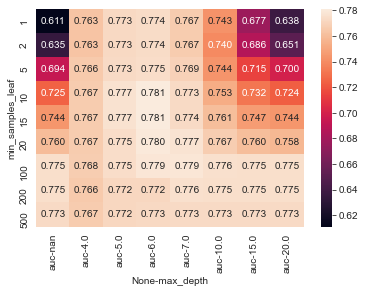

In [200]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'auc'])
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

In [201]:
# Best max depth for decision tree classifier is 6, best number of min. samples = 15

decision_tree = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15, class_weight=weights)
dt.fit(X_train, y_train)
    
y_pred = dt.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(auc)
print(recall_score(y_test, y_pred))

0.7152725352153889
0.7172995780590717


Decision tree > logistic regression.

## Random Forest Classifier

In [202]:
from sklearn.ensemble import RandomForestClassifier

In [203]:
scores = []
for d in tqdm(range(5, 15)):
    for n in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1, class_weight=weights)
        rf.fit(X_train, y_train)
    
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
    
        scores.append((d, n, auc))    

  0%|                                                                                           | 0/10 [00:03<?, ?it/s]


KeyboardInterrupt: 

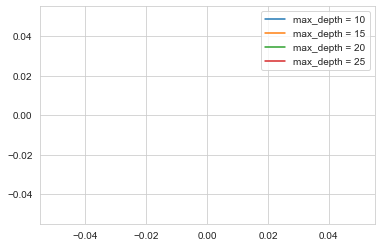

In [204]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'auc'])

for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label='max_depth = %s' % d)
plt.legend()

In [205]:
scores = []
max_depth = 10
for s in tqdm([1, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]):
    for n in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, min_samples_leaf=s, random_state=1, class_weight=weights)
        rf.fit(X_train, y_train)
    
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
    
        scores.append((s, n, auc))

  0%|                                                                                           | 0/12 [00:03<?, ?it/s]


KeyboardInterrupt: 

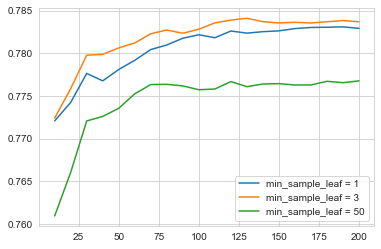

In [133]:
df_scores = pd.DataFrame(scores, columns=['min_sample_leaf', 'n_estimators', 'auc'])
for s in [1, 3, 50]:
    df_subset = df_scores[df_scores.min_sample_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.auc, label='min_sample_leaf = %s' % s)
plt.legend()

Optimal n_estimators ~130, optimal sample_leaf = 3, optimal max_depth = 10

In [206]:
rf = RandomForestClassifier(n_estimators=130, max_depth=10, min_samples_leaf=3, random_state=1, class_weight=weights)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_test)[:, 1]
y_pred
print(roc_auc_score(y_test, y_pred))
#print(recall_score(y_test, y_pred))

0.7812922452992502


## XGBoost

In [207]:
import xgboost as xgb

In [228]:
features = dv.get_feature_names()
#features.remove('company_size=<10')
#features.remove('experience=<1')
features

['city=city_1',
 'city=city_10',
 'city=city_100',
 'city=city_101',
 'city=city_102',
 'city=city_103',
 'city=city_104',
 'city=city_105',
 'city=city_106',
 'city=city_107',
 'city=city_109',
 'city=city_11',
 'city=city_111',
 'city=city_114',
 'city=city_115',
 'city=city_116',
 'city=city_117',
 'city=city_118',
 'city=city_12',
 'city=city_120',
 'city=city_121',
 'city=city_123',
 'city=city_126',
 'city=city_127',
 'city=city_128',
 'city=city_13',
 'city=city_131',
 'city=city_133',
 'city=city_134',
 'city=city_136',
 'city=city_138',
 'city=city_139',
 'city=city_14',
 'city=city_140',
 'city=city_141',
 'city=city_142',
 'city=city_143',
 'city=city_144',
 'city=city_145',
 'city=city_146',
 'city=city_149',
 'city=city_150',
 'city=city_152',
 'city=city_155',
 'city=city_157',
 'city=city_158',
 'city=city_159',
 'city=city_16',
 'city=city_160',
 'city=city_162',
 'city=city_165',
 'city=city_166',
 'city=city_167',
 'city=city_173',
 'city=city_175',
 'city=city_176',


In [321]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features, weight=classes_weights_train)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features, weight=classes_weights_val)

In [322]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1, 
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

[23:42:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [323]:
y_pred = model.predict(dval)
print(roc_auc_score(y_val, y_pred))
#print(recall_score(y_val, y_pred))

0.7852787360284518


In [233]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [324]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1, 
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=200, verbose_eval=5)

In [238]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [325]:
df_score = parse_xgb_output(output)
df_score

,num_iter,train_auc,val_auc
0,0,0.78954,0.77938
1,5,0.82216,0.78522
2,10,0.83737,0.78465
3,15,0.84539,0.78400
4,20,0.84998,0.78368
5,25,0.85500,0.78286
6,30,0.85964,0.78239
7,35,0.86463,0.78124
8,40,0.86849,0.78080
9,45,0.87154,0.78029


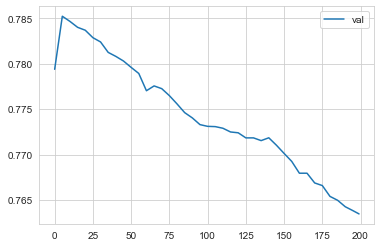

In [326]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

In [353]:
scores = {}

Highest num_iter = 10

In [336]:
%%capture output

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'min_child_weight': 1, 
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=200, verbose_eval=5)

In [337]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

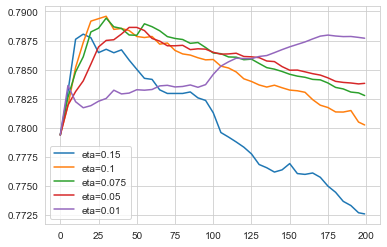

In [338]:
etas = ['eta=0.15', 'eta=0.1', 'eta=0.075', 'eta=0.05', 'eta=0.01']
for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)
plt.legend()

In [350]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 8,
    'min_child_weight': 1, 
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=200, verbose_eval=5)

In [351]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)

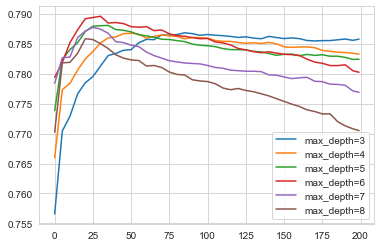

In [352]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)
plt.legend()

In [367]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 30, 
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=200, verbose_eval=5)

In [368]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)

(0.7875, 0.7925)

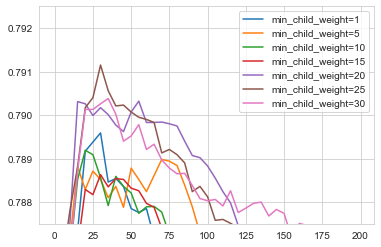

In [369]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)
plt.legend()
plt.ylim(.7875, .7925)

num_iter = 30, eta = 0.1, max_depth = 6, min_child_weight = 25

In [370]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 25, 
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=25)

In [371]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.7901490744872952

## **Final comparisons**

In [372]:
weights = {0: .25, 1: .75}

wlr = LogisticRegression(random_state=1, class_weight=weights)
rf = RandomForestClassifier(n_estimators=130, max_depth=10, min_samples_leaf=3, random_state=1, class_weight=weights)
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15, class_weight=weights)

In [450]:
y_full_train = df_full_train.target.values()

TypeError: 'numpy.ndarray' object is not callable

In [410]:
df_full_train = df_full_train.drop('target', axis=1)

In [452]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [455]:
classes_weights_test = class_weight.compute_sample_weight(
    class_weight=weights,
    y=y_test
)

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 25, 
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [413]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=dv.get_feature_names(), weight=classes_weights_full_train)

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names())

In [414]:
boost = xgb.train(xgb_params, dfulltrain, num_boost_round=30)

In [460]:
# Weighted Logistic Regression
wlr.fit(X_full_train, y_full_train)
y_pred = wlr.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_pred, sample_weight=classes_weights_test))

0.7643778492716984


C:\Users\Luke Luo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [461]:
# Decision Tree
dt.fit(X_full_train, y_full_train)
y_pred = dt.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_pred, sample_weight = classes_weights_test))

0.5


In [462]:
# Random Forest
rf.fit(X_full_train, y_full_train)
y_pred = rf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_pred, sample_weight=classes_weights_test))

0.7786300599261456


In [463]:
# XGB model
y_pred = boost.predict(dtest)
print(roc_auc_score(y_test, y_pred, sample_weight=classes_weights_test))

0.7818986756555885


0.0

# Based on the test evaluation, the XGBoost model has the best performance.